# MONAI : Tutorial : 2d_classification

## Medical Image Classification Tutorial with the MedNIST Dataset

参照URL:
- https://github.com/Project-MONAI/tutorials/tree/main/2d_classification
- https://www.classcat.com/medical_ai/2022/11/02/monai-1-0-tutorials-2d-classification-mednist/

注) torch-1.13.1+cu117では正常動作せず. ⇒ torch-1.12.0+cu113

## 0. 準備

In [1]:
# パッケージのインポート
import warnings
warnings.simplefilter('ignore')

import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# ML
import torch
from sklearn.metrics import classification_report

# MONAI
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.24.1
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: /home/aska/anaconda3/envs/monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED 

In [2]:
# データフォルダ
root_dir = os.path.realpath('./data')
print(root_dir)

/data/MONAI


In [3]:
# データのダウンロード
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, 'MedNIST.tar.gz')
data_dir = os.path.join(root_dir, 'MedNIST')
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [4]:
# 乱数シードの設定
set_determinism(seed=2023)

## 1. データの可視化

Dataset :
- Hand
- AbdomenCT
- CXR
- ChestCT
- BreastMRI
- HeadCT

### 1.1 データ関連情報の表示

In [5]:
# データセットのディレクトリ名からクラス名に
class_names = sorted(x for x in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

# クラス毎に画像ファイルのリスト作成
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]

# 各画像ファイルのリストから全体の画像ファイルとクラスのリスト
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")


Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


### 1.2 画像の表示

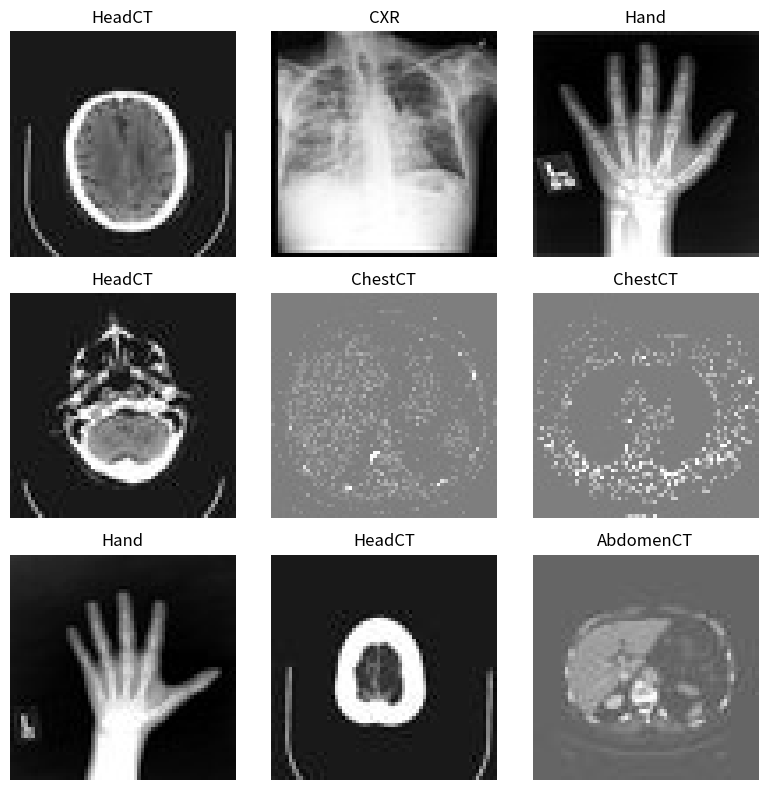

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.title(class_names[image_class[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. 学習
### 2.1 学習/評価/テストに分割

In [7]:
# train_data/val_data/test_data = 0.8/0.1/0.1
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(length * test_frac)
val_split = int(length * val_frac) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


### 2.2 データ・セット, データローダ

In [8]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
    ]
)

In [9]:
y_pred_trans = Compose([Activations(softmax=True)])

y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [10]:
# データセットクラス
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [11]:
# データセット & データローダ
BATCH_SIZE = 300

train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=10)

### 2.3 モデル構築

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
auc_metric = ROCAUCMetric()

### 2.4 モデル学習

In [13]:
max_epochs = 4
val_interval = 1

In [14]:
# モデル学習ループ
model_dir = os.path.realpath('./models')

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

epoch_len = len(train_ds) // train_loader.batch_size
# epochループ
for epoch in range(max_epochs):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # min batchループ
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
        )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # 評価データによる評価
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 
                          os.path.join(root_dir, 'best_metric_model.path'))
                print('saved new best metric model')
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
)

----------
epoch 1/4
1/157, train_loss: 1.7918
2/157, train_loss: 1.7435
3/157, train_loss: 1.7377
4/157, train_loss: 1.7683
5/157, train_loss: 1.7011
6/157, train_loss: 1.6797
7/157, train_loss: 1.6412
8/157, train_loss: 1.6258
9/157, train_loss: 1.6400
10/157, train_loss: 1.5963
11/157, train_loss: 1.5538
12/157, train_loss: 1.5377
13/157, train_loss: 1.5232
14/157, train_loss: 1.4621
15/157, train_loss: 1.4427
16/157, train_loss: 1.4526
17/157, train_loss: 1.4352
18/157, train_loss: 1.3597
19/157, train_loss: 1.3730
20/157, train_loss: 1.3681
21/157, train_loss: 1.3227
22/157, train_loss: 1.3611
23/157, train_loss: 1.2870
24/157, train_loss: 1.2884
25/157, train_loss: 1.2669
26/157, train_loss: 1.2622
27/157, train_loss: 1.2268
28/157, train_loss: 1.2167
29/157, train_loss: 1.2038
30/157, train_loss: 1.1860
31/157, train_loss: 1.1239
32/157, train_loss: 1.1503
33/157, train_loss: 1.0949
34/157, train_loss: 1.0702
35/157, train_loss: 1.0721
36/157, train_loss: 1.0667
37/157, train_lo

137/157, train_loss: 0.0969
138/157, train_loss: 0.0933
139/157, train_loss: 0.0874
140/157, train_loss: 0.1082
141/157, train_loss: 0.1267
142/157, train_loss: 0.0959
143/157, train_loss: 0.0982
144/157, train_loss: 0.1000
145/157, train_loss: 0.1042
146/157, train_loss: 0.0931
147/157, train_loss: 0.0837
148/157, train_loss: 0.0949
149/157, train_loss: 0.1048
150/157, train_loss: 0.0912
151/157, train_loss: 0.0916
152/157, train_loss: 0.0906
153/157, train_loss: 0.0966
154/157, train_loss: 0.0960
155/157, train_loss: 0.0766
156/157, train_loss: 0.0830
157/157, train_loss: 0.0916
158/157, train_loss: 0.0697
epoch 2 average loss: 0.1435
saved new best metric model
current epoch: 2 current AUC: 0.9997 current accuracy: 0.9866 best AUC: 0.9997 at epoch: 2
----------
epoch 3/4
1/157, train_loss: 0.0900
2/157, train_loss: 0.0955
3/157, train_loss: 0.1112
4/157, train_loss: 0.0936
5/157, train_loss: 0.0828
6/157, train_loss: 0.0872
7/157, train_loss: 0.0858
8/157, train_loss: 0.0698
9/157, 

110/157, train_loss: 0.0282
111/157, train_loss: 0.0389
112/157, train_loss: 0.0371
113/157, train_loss: 0.0318
114/157, train_loss: 0.0424
115/157, train_loss: 0.0374
116/157, train_loss: 0.0348
117/157, train_loss: 0.0428
118/157, train_loss: 0.0401
119/157, train_loss: 0.0259
120/157, train_loss: 0.0326
121/157, train_loss: 0.0243
122/157, train_loss: 0.0277
123/157, train_loss: 0.0386
124/157, train_loss: 0.0372
125/157, train_loss: 0.0363
126/157, train_loss: 0.0253
127/157, train_loss: 0.0297
128/157, train_loss: 0.0462
129/157, train_loss: 0.0358
130/157, train_loss: 0.0206
131/157, train_loss: 0.0411
132/157, train_loss: 0.0299
133/157, train_loss: 0.0339
134/157, train_loss: 0.0329
135/157, train_loss: 0.0382
136/157, train_loss: 0.0293
137/157, train_loss: 0.0336
138/157, train_loss: 0.0333
139/157, train_loss: 0.0535
140/157, train_loss: 0.0275
141/157, train_loss: 0.0323
142/157, train_loss: 0.0286
143/157, train_loss: 0.0240
144/157, train_loss: 0.0227
145/157, train_loss:

### 2.5 学習履歴

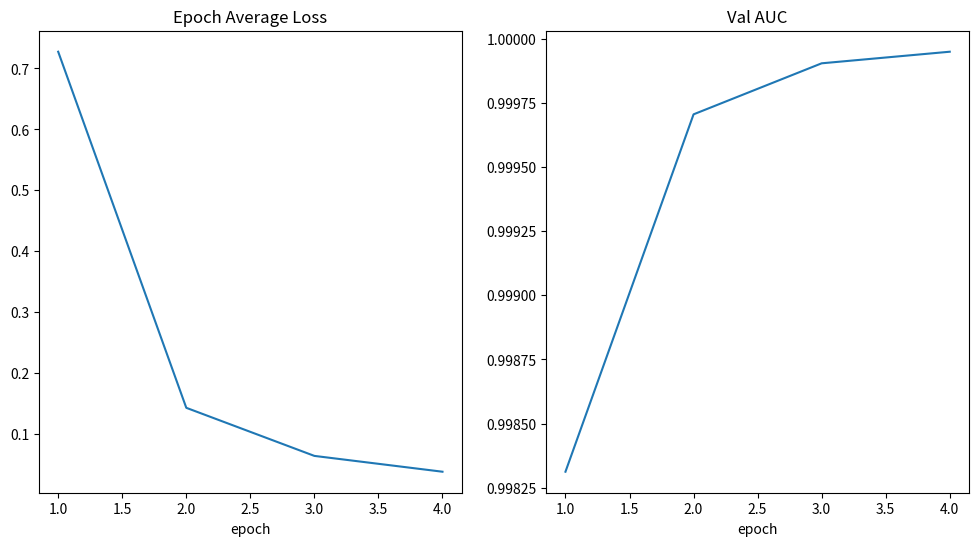

In [15]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title('Val AUC')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## 3. 評価

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, 'best_metric_model.pth')))
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))